# Estimating GGM using Score Matching

In [2]:
import HD, NPGM, BSpline
# reload("HD")
# reload("NPGM")

Generate Gaussian data from which we will be learning the structure. The covariance is a Toeplitz matrix, that is, $\Sigma = (\sigma_{ab})$ with $\sigma_{ab} = \rho^{|a-b|}$.

In [3]:
function gen_data_chain(n::Int64, p::Int64, rho::Float64; zero_thr=1e-4)

    Sigma = zeros(Float64, p, p)
    for a=1:p
        for b=1:p
            Sigma[a,b] = rho^abs(a-b)
        end
    end
    Theta = inv(Sigma)
    Theta[find(abs(Theta) .< zero_thr)] = 0.
    
    X = randn(n, p) * sqrtm(Sigma), Sigma, Theta
end

gen_data_chain (generic function with 1 method)

Run Group Lasso

In [9]:
K = 1
L = 1
n = 500
p = 100
rho = 0.8
numColumns = int(p*K+p*(p-1)/2*L)
groups = Array(Array{Int64, 1}, numColumns)
for i=1:numColumns
    groups[i] = [i]
end
mask = ones(Float64, numColumns)
mask[1:p*K] = 0.;

In [10]:
numRep = 5
lambdaArr = logspace(log10(3), log10(0.3), 30)
numLambda = length(lambdaArr)
pathSol = cell(numRep, numLambda)

@time for rep = 1:numRep
    X, _, _ = gen_data_chain(n,p,rho)
    
    DD = NPGM.getDD(X, K, L, NPGM.gm_node_der_f, NPGM.gm_edge_der_f)
    E = NPGM.getE(X, K, L, NPGM.gm_node_der_2_f, NPGM.gm_edge_der_2_f)
    
    scale!(E, -1./n)   # note -1 because of group lasso interface
    scale!(DD, 1./n)    
    
    solution = zeros(Float64, numColumns)
    for indLambda=1:numLambda
        HD.group_lasso!(solution, DD, E, groups, lambdaArr[indLambda]*mask)
        
        solution[find(abs(solution) .< 1e-4)] = 0.
        eThetaSp = zeros(Float64, p, p)
        NPGM.getPrecision(eThetaSp, p, solution)
        pathSol[rep, indLambda] = eThetaSp        
    end
end

elapsed time: 216.261699445 seconds (33859976660 bytes allocated, 11.11% gc time)


In [11]:
Sigma = zeros(Float64, p, p)
for a=1:p
    for b=1:p
        Sigma[a,b] = rho^abs(a-b)
    end
end
Theta = inv(Sigma)
Theta[find(abs(Theta) .< 1e-4)] = 0.

trueSparsity = spones(sparse(Theta))

hammingDistance = zeros(numRep, numLambda)
for rep=1:numRep
    for indLambda=1:numLambda    
        estimSparsity = spones(sparse(pathSol[rep, indLambda]))    
        hammingDistance[rep, indLambda] = nnz(trueSparsity - estimSparsity) / 2.
    end
end

In [7]:
using PyPlot

INFO: Loading help data...


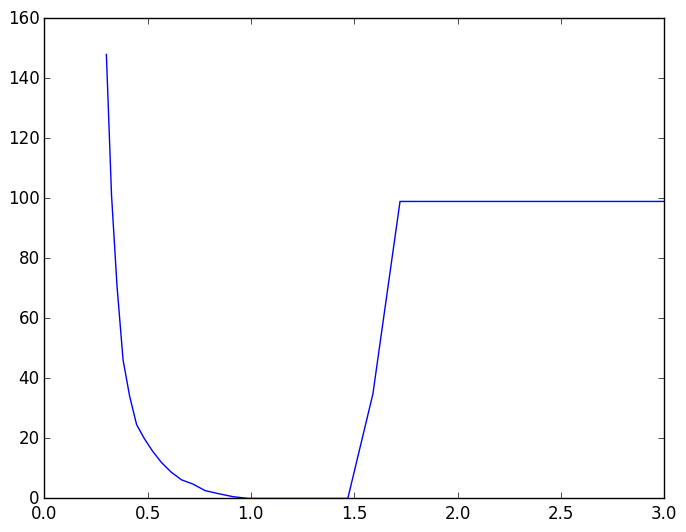

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f398da7dc50>

In [12]:
plot(lambdaArr, vec(mean(hammingDistance, 1)))

### Slow ways to compute DD

In [9]:
# # This should not be run -- slower
# D = getD(X, 1, K, L, phi_node_der, phi_edge_der)
# DD1 = D'D
# @time for i=2:n
#     D = getD(X, i, K, L, phi_node_der, phi_edge_der)    
#     tnz = (D'D).nzval
#     DDnz = DD1.nzval    
#     for j=1:length(DDnz)
#         @inbounds DDnz[j] = DDnz[j] + tnz[j]
#     end
# end
# @time E = getE(X, K, L, phi_node_der_2, phi_edge_der_2);

In [10]:
# # This should not be run -- shows how slow the other approach is
# DD1 = zeros(Float64, numFeatures, numFeatures)
# @time for i=1:n
#     D = getD(X, i, K, L, phi_node_der, phi_edge_der)
#     broadcast!(+, DD1, DD1, D'D)
# end
# # DD = sparse(DD);
# @time E = getE(X, K, L, phi_node_der_2, phi_edge_der_2);
# maximum(abs(DD1-DD))

###Test case 

Without penalty, we should get back the inverse of the covariance matrix.

In [59]:
eTmp = -DD \ E
eTheta = zeros(Float64, p, p)
getPrecision(eTheta, p, eTmp)
maximum(abs(eTheta - inv(X'X/n)))

CHOLMOD warning: matrix not positive definite


13.164281562842719

### Speed comparison

In [85]:
D = getD(X, 1, K, L, phi_node_der, phi_edge_der)
DD = D'D
@time for i=2:n
    D = getD(X, i, K, L, phi_node_der, phi_edge_der)
    broadcast!(+, DD.nzval, DD.nzval, (D'D).nzval)
end
@time E = getE(X, K, L, phi_node_der_2, phi_edge_der_2);
@time DD1 = getDD(X, K, L, phi_node_der, phi_edge_der);

LoadError: getD not defined
while loading In[85], in expression starting on line 1

# BSpline Version

In [78]:
function createNodeFunction(M, xmin, xmax, numKnots)
   
    bs = BSpline.BSplineT(M, xmin, xmax, numKnots)
    K = BSpline.num_basis(bs)
    
    f_node(x, k)      = BSpline.bspline_basis(k-1, bs, x)
    f_node_der(x, k)  = BSpline.derivative_bspline_basis(k-1, bs, x)
    f_node_der2(x, k) = BSpline.derivative2_bspline_basis(k-1, bs, x)
    
    (f_node, f_node_der, f_node_der2, K)
end

function createEdgeFunction(M, xmin, xmax, numKnots)
   
    bs1 = BSpline.BSplineT(M, xmin[1], xmax[1], numKnots[1])
    bs2 = BSpline.BSplineT(M, xmin[2], xmax[2], numKnots[2])
    L1 = BSpline.num_basis(bs1) 
    L2 = BSpline.num_basis(bs2)
    
    function f_edge(x, y, l) 
        r, c = ind2sub((L1, L2), l)
        r -= 1
        c -= 1
        return BSpline.bspline_basis(r, bs1, x) * BSpline.bspline_basis(c, bs2, y)
    end    
    function f_edge_der(x, y, l, whichArgument) 
        r, c = ind2sub((L1, L2), l)
        r -= 1
        c -= 1
        if whichArgument == 1
            return BSpline.derivative_bspline_basis(r, bs1, x) * BSpline.bspline_basis(c, bs2, y)
        else
            return BSpline.bspline_basis(r, bs1, x) * BSpline.derivative_bspline_basis(c, bs2, y)
        end
    end
    function f_edge_der2(x, y, l, whichArgument) 
        r, c = ind2sub((L1, L2), l)
        r -= 1
        c -= 1
        if whichArgument == 1
            return BSpline.derivative2_bspline_basis(r, bs1, x) * BSpline.bspline_basis(c, bs2, y)
        else
            return BSpline.bspline_basis(r, bs1, x) * BSpline.derivative2_bspline_basis(c, bs2, y)
        end
    end
    
    (f_edge, f_edge_der, f_edge_der2, L1*L2)
end
(phi_node, phi_node_der, phi_node_der2, K) = createNodeFunction(4, -4., 4., 6)
(phi_edge, phi_edge_der, phi_edge_der2, L) = createEdgeFunction(4, (-4., -4.), (4., 4.), (4,4));

In [79]:
n = 1000
p = 3
rho = 0.4
X, _, _ = gen_data_chain(n,p,rho);

In [11]:
# D = NPGM.getD(X, 1, K, L, phi_node_der, phi_edge_der)
# DD = D'D
# @time for i=2:n
#     D = NPGM.getD(X, i, K, L, phi_node_der, phi_edge_der)
#     DD += D'D
# end
# @time DD1 = NPGM.getDD(X, K, L, phi_node_der, phi_edge_der);

elapsed time: 407.621929005 seconds (557471916424 bytes allocated, 7.44% gc time)
elapsed time: 42.827687641 seconds (7513576032 bytes allocated, 7.57% gc time)


# Spline neighborhood

In [9]:
# D = NPGM.getNeighborhoodD(X, 2, 1, K, L, phi_node_der, phi_edge_der)
# out = zeros(K+(p-1)*L, 2)
# NPGM.getNeighborhoodD!(out, X, 2, 1, K, L, phi_node_der, phi_edge_der)

In [50]:
# D = NPGM.getNeighborhoodD(X, 1, 1, K, L, phi_node_der, phi_edge_der)
# DD = D'D
# @time for i=2:n
#     D = NPGM.getNeighborhoodD(X, i, 1, K, L, phi_node_der, phi_edge_der)
#     DD += D'D
# end
# @time DD1 = NPGM.getNeighborhoodDD(X, 1, K, L, phi_node_der, phi_edge_der);

elapsed time: 0.015566065 seconds (39199128 bytes allocated)
elapsed time: 0.042158894 seconds (9663648 bytes allocated, 76.99% gc time)


In [80]:
@time DD = NPGM.getNeighborhoodDD(X, 1, K, L, phi_node_der, phi_edge_der);
@time E = NPGM.getNeighborhoodE(X, 1, K, L, phi_node_der2, phi_edge_der2);

elapsed time: 0.215878887 seconds (107147364 bytes allocated, 34.81% gc time)
elapsed time: 0.21297679 seconds (110550052 bytes allocated, 46.99% gc time)


In [84]:
numGroups = p
groups = Array(Array{Int64, 1}, numGroups)
groups[1] = [1:K]
for j=1:p-1
    groups[j+1] = [K+(j-1)*L+1:K+j*L]
end
lambda = zeros(p)
lambda[1] = 0.
for j=1:p-1
    lambda[j+1] = 1
end
# beta = zeros(K+(p-1)*L); 

In [85]:
HD.group_lasso!(beta, DD, -E, groups, lambda)

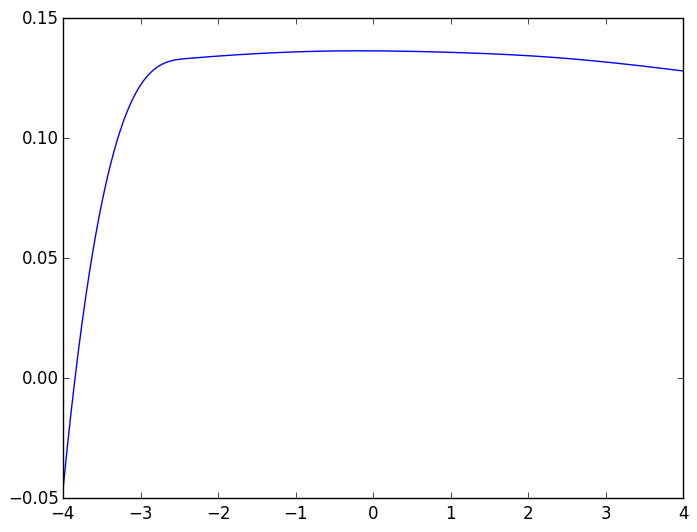

In [88]:
x0 = [0, 0]
testX = linspace(-4., +4, 1000)
psiX = zeros(length(testX), K+(p-1)*L)
for i=1:length(testX)
    for j=1:K
        psiX[i, j] = phi_node(testX[i], j)
    end
    for b=1:p-1
        for l=1:L
            psiX[i, K+(b-1)*L+l] = phi_edge(testX[i], x0[b], l)
        end
    end
end
f = psiX * beta;
c0 = ExpFamilyGM.trapz(f, -4., 4.)
PyPlot.plot(testX, f/c0);

In [67]:
import PyPlot

INFO: Loading help data...


In [69]:
import ExpFamilyGM

In [86]:
beta'

1x80 Array{Float64,2}:
 -885.006  123.003  128.535  131.904  …  0.0112406  0.0212815  0.00213655